# Diffusion Model

Let's Code the Forward Process first

Beta:  [9.99999975e-05 6.04040397e-04 1.10808085e-03 1.61212124e-03
 2.11616163e-03 2.62020202e-03 3.12424242e-03 3.62828281e-03
 4.13232343e-03 4.63636359e-03 5.14040422e-03 5.64444438e-03
 6.14848500e-03 6.65252516e-03 7.15656579e-03 7.66060594e-03
 8.16464610e-03 8.66868719e-03 9.17272735e-03 9.67676751e-03
 1.01808077e-02 1.06848488e-02 1.11888889e-02 1.16929291e-02
 1.21969692e-02 1.27010103e-02 1.32050505e-02 1.37090907e-02
 1.42131317e-02 1.47171719e-02 1.52212121e-02 1.57252531e-02
 1.62292924e-02 1.67333335e-02 1.72373746e-02 1.77414138e-02
 1.82454549e-02 1.87494941e-02 1.92535352e-02 1.97575763e-02
 2.02616155e-02 2.07656566e-02 2.12696977e-02 2.17737369e-02
 2.22777780e-02 2.27818191e-02 2.32858583e-02 2.37898994e-02
 2.42939387e-02 2.47979797e-02 2.53020208e-02 2.58060601e-02
 2.63101012e-02 2.68141422e-02 2.73181815e-02 2.78222226e-02
 2.83262618e-02 2.88303029e-02 2.93343440e-02 2.98383832e-02
 3.03424243e-02 3.08464654e-02 3.13505046e-02 3.18545438e-02
 3.23585868e-02 3

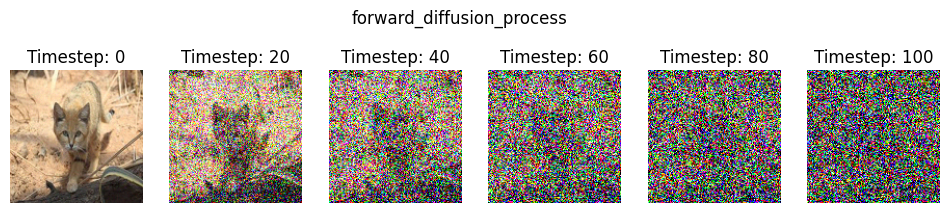

In [3]:
import os
import scipy
import urllib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def forward_diffusion_process(img_prev, beta, t):
    beta_t = beta[t].reshape(-1, 1, 1)
    
    #Calculate mean and variance
    mu = np.sqrt((1.0 - beta_t)) * img_prev
    sigma = np.sqrt(beta_t)
    
    #Obtain image at timestep t using equation
    img_t = mu + sigma * np.random.randn(*img_prev.shape)
    return img_t


#Input
img = Image.open("C:\\Users\\Tudor\\Pictures\\cats_\\ras.jpg")
IMG_SIZE = (128, 128)
img = img.resize(size=IMG_SIZE)
img_curr = np.asarray(img.copy(), dtype=np.float32) / 255.

#Parameters
timesteps = 100
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)

print("Beta: ", beta)

processed_images = []

# Run the forward process to obtain img after t timesteps
for t in range(timesteps):
    img_curr = forward_diffusion_process(img_prev=img_curr, beta=beta, t=t)
    if t%20==0 or t==timesteps - 1:
        sample = (img_curr.clip(0, 1) * 255.0).astype(np.uint8)
        processed_images.append(sample)

#Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(12, 5))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("forward_diffusion_process", y=0.75)
plt.show()

ok pretty cool

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== Dataset Setup ====================

def get_dataset(dataset_name="cifar10", batch_size=32, image_size=32, target_class=None):
    """
    Get dataset - you can choose between:
    - 'cifar10': Small color images (32x32)
    - 'mnist': Handwritten digits
    - 'custom': Your own dataset
    """
    if dataset_name == "cifar10":
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])
        
        train_dataset = datasets.CIFAR10(
            root='./data', 
            train=True, 
            download=True, 
            transform=transform
        )

        if target_class is not None:
            indices = [i for i, (_, label) in enumerate(train_dataset) if label == target_class]
            train_dataset = torch.utils.data.Subset(train_dataset, indices)
            print(f"Selected {len(indices)} images from class {target_class}")
        
    elif dataset_name == "mnist":
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert to 3 channels
            transforms.Normalize([0.5], [0.5])
        ])
        
        train_dataset = datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )

        if target_class is not None:
            indices = [i for i, (_, label) in enumerate(train_dataset) if label == target_class]
            train_dataset = torch.utils.data.Subset(train_dataset, indices)
            print(f"Selected {len(indices)} images from class {target_class}")
    
    elif dataset_name == "custom":
        # For custom dataset, create a folder with your images
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
        train_dataset = datasets.ImageFolder(
            root='./custom_data',  # Put your images here
            transform=transform
        )

        if target_class is not None:
            # Get the class index
            class_to_idx = train_dataset.class_to_idx
            if target_class in class_to_idx:
                class_idx = class_to_idx[target_class]
                indices = [i for i, (_, label) in enumerate(train_dataset) if label == class_idx]
                train_dataset = torch.utils.data.Subset(train_dataset, indices)
                print(f"Selected {len(indices)} images from class '{target_class}'")
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader, train_dataset

Using device: cpu


In [5]:
# ==================== Model Components ====================

class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal position embeddings for time steps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    """Basic convolutional block with time embedding"""
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    
    def forward(self, x, t):
        # First convolution
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Add time embedding to each channel
        h = h + time_emb[(..., ) + (None, ) * 2]
        # Second convolution
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Downsample or upsample
        return self.transform(h)

class SimpleUnet(nn.Module):
    """Simplified U-Net architecture for diffusion"""
    def __init__(self, image_channels=3, down_channels=(64, 128, 256, 512, 1024)):
        super().__init__()
        
        # Time embedding
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        
        # Downsample
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim) 
            for i in range(len(down_channels)-1)
        ])
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(down_channels[-1], down_channels[-1], 3, padding=1),
            nn.BatchNorm2d(down_channels[-1]),
            nn.ReLU(),
            nn.Conv2d(down_channels[-1], down_channels[-1], 3, padding=1)
        )
        
        # Upsample
        up_channels = down_channels[::-1]
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
            for i in range(len(up_channels)-1)
        ])
        
        # Final
        self.final = nn.Sequential(
            nn.Conv2d(up_channels[-1], 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, image_channels, 1)
        )
    
    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        
        # Initial conv
        x = self.conv0(x)
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        
        x = self.bottleneck(x)
        
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        
        return self.final(x)

# ==================== Diffusion Process ====================

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=32, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        # Prepare beta schedule
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_images(self, x, t):
        """Add noise to images at specific timesteps"""
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon
    
    def sample_timesteps(self, n):
        """Sample random timesteps"""
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        """Generate samples from noise"""
        print(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2  # Convert to [0, 1]
        x = (x * 255).type(torch.uint8)
        return x

# ==================== Training Function ====================

def train(model, diffusion, dataloader, optimizer, epochs=50, device=device):
    """Train the diffusion model"""
    model.to(device)
    mse = nn.MSELoss()
    
    for epoch in range(epochs):
        pbar = tqdm(dataloader)
        total_loss = 0
        
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            
            # Sample random timesteps
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            
            # Add noise
            x_t, noise = diffusion.noise_images(images, t)
            
            # Predict noise
            predicted_noise = model(x_t, t)
            
            # Calculate loss
            loss = mse(noise, predicted_noise)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
        
        # Generate samples every 5 epochs
        if (epoch + 1) % 5 == 0:
            samples = diffusion.sample(model, n=8)
            save_samples(samples, epoch+1)

def save_samples(samples, epoch, nrow=4):
    """Save generated samples"""
    from torchvision.utils import make_grid
    
    grid = make_grid(samples, nrow=nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.title(f"Generated Images - Epoch {epoch}")
    plt.axis('off')
    plt.savefig(f"samples_epoch_{epoch}.png", bbox_inches='tight')
    plt.close()


In [ ]:
def main(EPOCHS=5, model=None):
    # Hyperparameters
    IMAGE_SIZE = 32
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    DATASET = "cifar10"
    
    # Get dataset
    print("Loading dataset...")
    train_loader, _ = get_dataset(
        dataset_name=DATASET,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        target_class=3, # Cat
    )

    print(len(train_loader))
    
    # Initialize model and diffusion
    if model == None:
        print("Initializing model...")
        model = SimpleUnet(image_channels=3)
        diffusion = Diffusion(img_size=IMAGE_SIZE, device=device)
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train
    print("Starting training...")
    train(
        model=model,
        diffusion=diffusion,
        dataloader=train_loader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    )
    
    # Save model
    torch.save(model.state_dict(), "diffusion_model.pth")
    print("Model saved as 'diffusion_model.pth'")
    return model

In [7]:
def generate_images(model_path="diffusion_model.pth", num_images=16, image_size=32):
    """Generate new images from trained model"""
    # Load model
    model = SimpleUnet(image_channels=3)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Initialize diffusion
    diffusion = Diffusion(img_size=image_size, device=device)
    
    # Generate samples
    print(f"Generating {num_images} images...")
    samples = diffusion.sample(model, num_images)
    
    # Save images
    os.makedirs("generated", exist_ok=True)
    for i in range(num_images):
        img = samples[i].permute(1, 2, 0).cpu().numpy()
        img = Image.fromarray(img)
        img.save(f"generated/image_{i+1:03d}.png")
    
    # Create grid
    from torchvision.utils import make_grid
    grid = make_grid(samples[:16], nrow=4)
    grid = grid.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.title("Generated Images")
    plt.axis('off')
    plt.savefig("generated_grid.png", bbox_inches='tight')
    plt.show()

    print(f"Images saved in 'generated/' folder")
    

In [11]:
model = main(EPOCHS=20) # train it for 5 more epochs

Loading dataset...
Files already downloaded and verified


KeyboardInterrupt: 

C:\Users\Tudor\AppData\Local\Temp\ipykernel_25872\3537261959.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Generating 4 images...
Sampling 4 new images....


999it [13:08,  1.27it/s]


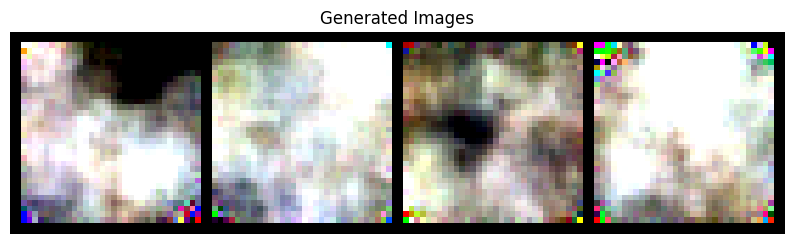

Images saved in 'generated/' folder


In [9]:
generate_images(num_images=4)

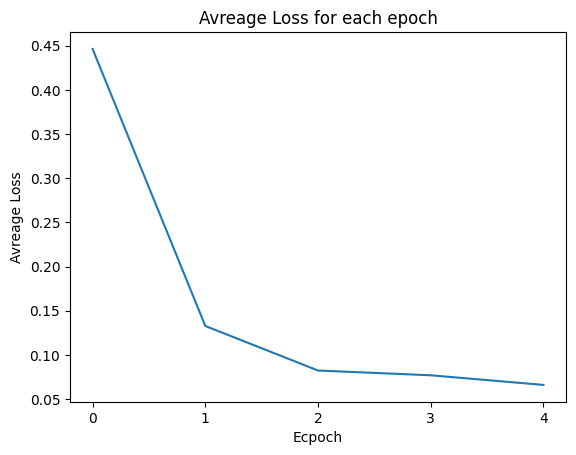

[0.4463, 0.1328, 0.0824, 0.077, 0.0661]

In [10]:
epochs = range(5)
avg_loss = [0.4463, 0.1328, 0.0824, 0.0770, 0.0661]

plt.plot(epochs, avg_loss)
plt.xticks(epochs)
plt.title("Avreage Loss for each epoch")
plt.xlabel("Ecpoch")
plt.ylabel("Avreage Loss")
plt.show()
avg_loss